In [2]:
! /home/corey/anaconda3/envs/forecastingEnv3/bin/python3.7 -m pip install xgboost

     |████████████████████████████████| 173.6 MB 48.4 MB/s eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product

from xgboost import XGBRegressor
from xgboost import plot_importance

In [16]:
train_data = pd.read_csv("/home/Dropbox/MyData/PredictSales/sales_train.csv")
test_data = pd.read_csv("/home/Dropbox/MyData/PredictSales/test.csv")
items_data = pd.read_csv("/home/Dropbox/MyData/PredictSales/items.csv")
shops_data = pd.read_csv("/home/Dropbox/MyData/PredictSales/shops.csv")
cate_data = pd.read_csv("/home/Dropbox/MyData/PredictSales/item_categories.csv")

### EDA

In [5]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
train_data.shape

(2935849, 6)

In [7]:
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

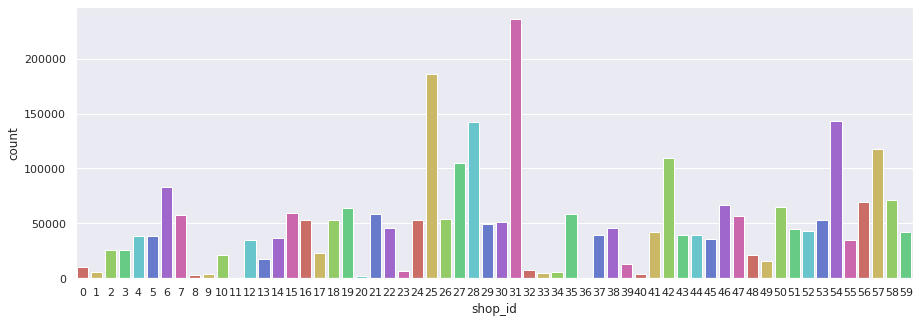

In [8]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=train_data['shop_id'], data=train_data, palette=color)

/home/corey/anaconda3/envs/forecastingEnv3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


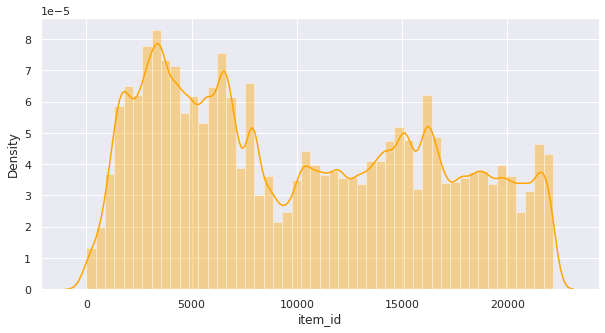

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(train_data['item_id'], color="orange");

/home/corey/anaconda3/envs/forecastingEnv3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


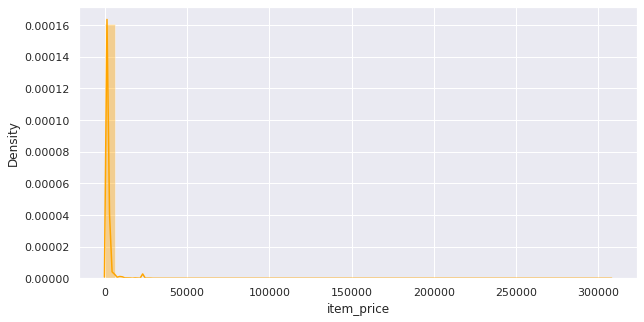

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(train_data['item_price'], color="orange");

/home/corey/anaconda3/envs/forecastingEnv3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/corey/anaconda3/envs/forecastingEnv3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


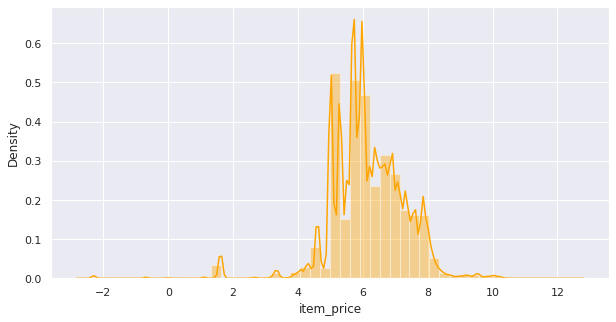

In [11]:
plt.figure(figsize=(10, 5))
sns.distplot(np.log(train_data['item_price']), color="orange");

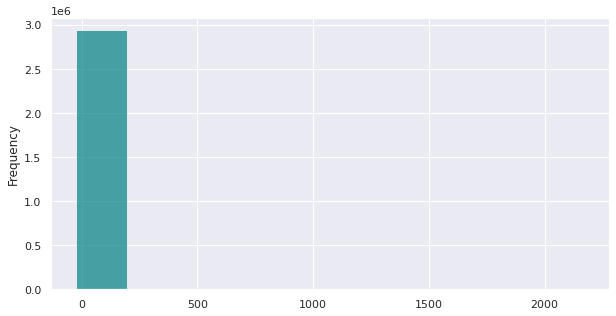

In [12]:
plt.figure(figsize=(10, 5))
train_data['item_cnt_day'].plot(kind='hist', alpha=0.7, color='teal')

In [17]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
test_data.shape

(214200, 3)

In [19]:
len(test_data['shop_id'].unique())

42

In [20]:
len(test_data['item_id'].unique())

5100

In [21]:
5100 * 42

214200

Every Shop contains every item

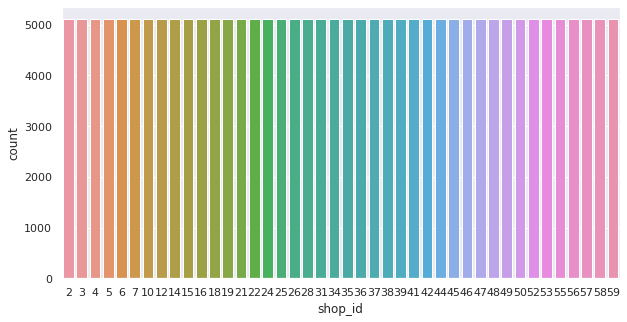

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(x=test_data['shop_id'], data=test_data)

/home/corey/anaconda3/envs/forecastingEnv3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


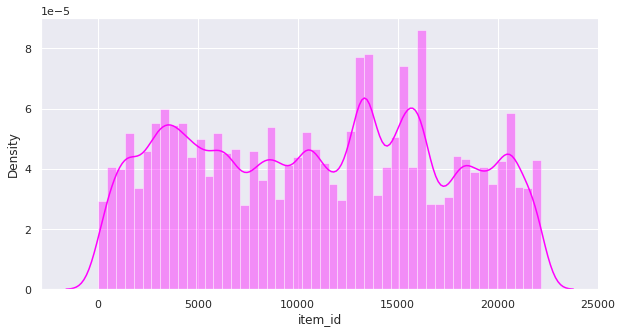

In [23]:
plt.figure(figsize=(10, 5))
sns.distplot(test_data['item_id'], color="magenta");

### Feature Engineering

##### Outliers Count

In [24]:
train_data['item_cnt_day'].sort_values(ascending=False).head(5)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

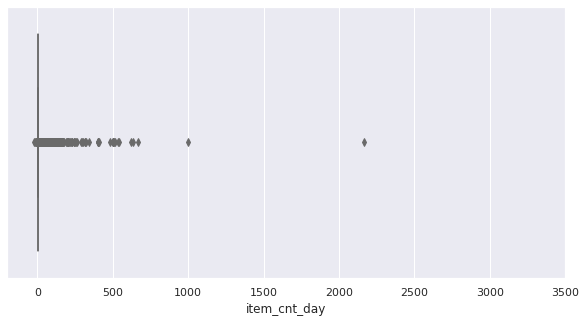

In [25]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(-200, 3500)
sns.boxplot(x=train_data.item_cnt_day, color="rose", palette="Set3")

In [26]:
train_data = train_data[train_data.item_cnt_day<=1000]

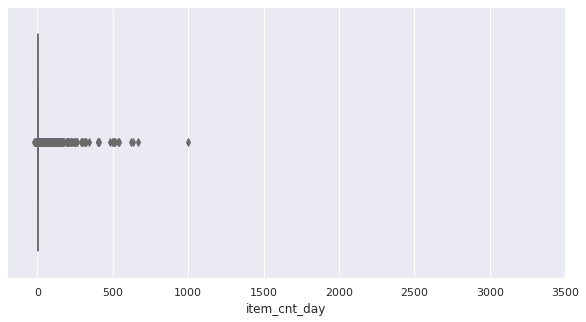

In [27]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(-200, 3500)
sns.boxplot(x=train_data.item_cnt_day, color="rose", palette="Set3")

#### Outliers of Item Price

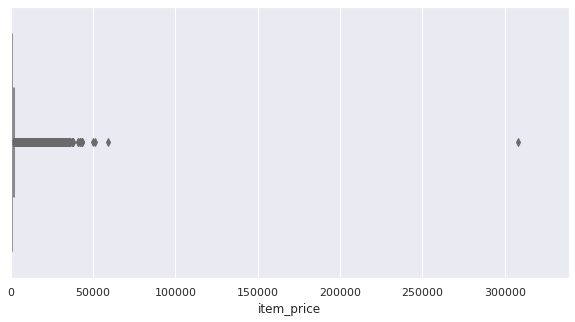

In [28]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(train_data.item_price.min(), train_data.item_price.max()*1.1)
sns.boxplot(x=train_data.item_price, color="green", palette="Set3")

In [29]:
train_data = train_data[train_data['item_price'] < 100000]

In [30]:
train_data[train_data['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [31]:
predict_mean_price = train_data[(train_data['date_block_num'] == 4) & (train_data['shop_id'] == 32) & (train_data['item_id'] == 2973) & (train_data['item_price'] > 0)]['item_price'].mean()

predict_mean_price

1874.0

In [32]:
train_data.loc[train_data['item_price'] < 0, 'item_price'] = predict_mean_price

In [33]:
train_data[(train_data['date_block_num'] == 4) & (train_data['shop_id'] == 32) & (train_data['item_id'] == 2973) & (train_data['item_price'] > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,1874.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


### Feature Analysis


#### Shops

In [34]:
unq_train_shops = train_data['shop_id'].unique()
unq_test_shops = test_data['shop_id'].unique()
print(len(unq_train_shops))
print(len(unq_test_shops))

60
42


In [35]:
set(unq_test_shops).issubset(set(unq_train_shops))

True

#### Duplicate Shop Handling

In [36]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [37]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string
    return (str1.join(s))

In [38]:
import re
for i, shop in enumerate(shops_data['shop_name']):
    if i == 6:
        pass
    else:
        string = shop
        cleanString = re.sub(r'[?|$|.|!]',r'',string)
        splitStr = cleanString.split()[:-1]
        finalStr = listToString(splitStr)
        result = shops_data[shops_data['shop_name'].str.contains(finalStr)]
        if result.shape == (2, 2) or result.shape == (0, 2):
            print(result)
            print('-'*50)

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
57        Якутск Орджоникидзе, 56       57
--------------------------------------------------
                        shop_name  shop_id
1   !Якутск ТЦ "Центральный" фран        1
58        Якутск ТЦ "Центральный"       58
--------------------------------------------------
                      shop_name  shop_id
7        Воронеж ТРЦ "Максимир"        7
8  Воронеж ТРЦ Сити-Парк "Град"        8
--------------------------------------------------
Empty DataFrame
Columns: [shop_name, shop_id]
Index: []
--------------------------------------------------
Empty DataFrame
Columns: [shop_name, shop_id]
Index: []
--------------------------------------------------
                  shop_name  shop_id
13      Казань ТЦ "Бехетле"       13
14  Казань ТЦ "ПаркХаус" II       14
--------------------------------------------------
                        shop_name  shop_id
17  Красноярск ТЦ "Взлетка Плаза"       17
18  

In [39]:
shops_data[shops_data['shop_name'].str.contains('Якутск ТЦ')]

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


In [40]:
train_data.loc[train_data.shop_id == 0, 'shop_id'] = 57
test_data.loc[test_data.shop_id == 0, 'shop_id'] = 57

train_data.loc[train_data.shop_id == 1, 'shop_id'] = 58
test_data.loc[test_data.shop_id == 1, 'shop_id'] = 58

train_data.loc[train_data.shop_id == 10, 'shop_id'] = 11
test_data.loc[test_data.shop_id == 10, 'shop_id'] = 11

#### Extract the City from Shops

In [41]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [42]:
shops_data.loc[shops_data['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [43]:
shops_data['city'] = shops_data['shop_name'].str.split(' ').map(lambda x:x[0])
shops_data.loc[shops_data['city'] == '!Якутск', 'city'] = 'Якутск'
shops_data.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [44]:
city_label_encoder = preprocessing.LabelEncoder()
shops_data['city_code'] = city_label_encoder.fit_transform(shops_data['city'])

In [45]:
shops_data = shops_data[['shop_id','city_code']]
shops_data.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


#### Analyzing Items

In [46]:
items_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [47]:
unq_train_item =  train_data['item_id'].unique()
unq_test_item =  test_data['item_id'].unique()
print(len(unq_train_item))
print(len(unq_test_item))

21806
5100


In [48]:
set(unq_test_item).issubset(set(unq_train_item))

False

In [49]:
len(set(unq_test_item).difference(set(unq_train_item)))

363

In [50]:
cat_in_test_data = items_data.loc[items_data['item_id'].isin(sorted(test_data['item_id'].unique()))].item_category_id.unique()
cat_in_test_data

array([40, 37, 41, 57, 54, 49, 43, 45, 44, 73, 76, 31, 78, 77, 55, 67, 75,
       58, 60, 56, 19, 30, 23, 20, 28, 24, 21, 29, 25, 72, 22, 26, 62, 74,
        0,  2,  5,  3, 35, 65, 27, 12, 64,  7,  6, 15, 34, 33, 16, 38, 42,
       61, 69, 70,  9, 36, 47, 11, 63, 79, 71, 83])

In [51]:
cat_not_in_test = cate_data[~cate_data['item_category_id'].isin(cat_in_test_data)].item_category_id.unique()
cat_not_in_test

array([ 1,  4,  8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59,
       66, 68, 80, 81, 82])

#### Categories Analysis

In [52]:
cate_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [53]:
splt_cate = cate_data['item_category_name'].str.split('-')
cate_data['main_cate'] = splt_cate.map(lambda x: x[0].strip())
cate_data['main_cate_id'] = preprocessing.LabelEncoder().fit_transform(cate_data['main_cate'])

cate_data['sub_cate'] = splt_cate.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cate_data['sub_cate_id'] = preprocessing.LabelEncoder().fit_transform(cate_data['sub_cate'])

cate_data = cate_data[['item_category_id', 'main_cate_id', 'sub_cate_id']]

In [54]:
cate_data.head()

,item_category_id,main_cate_id,sub_cate_id
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


#### Matrix Shop-Items

In [55]:
print('Item not in train:', len(set(unq_test_item).difference(set(unq_train_item))))
print('Total item in test:', len(test_data['item_id'].unique()))
print('Total shop in test:', len(test_data['shop_id'].unique()))

Item not in train: 363
Total item in test: 5100
Total shop in test: 42


In [56]:
ts = time.time()
matrix = []

months = train_data.date_block_num.unique()
for month in months:
    sales = train_data[train_data.date_block_num == month]
    unq_shop = sales['shop_id'].unique()
    unq_item = sales['item_id'].unique()
    append_arr = np.array(list(product(unq_shop, unq_item, [month])), dtype='int16')
    matrix.append(append_arr)

In [57]:
cols = ['shop_id','item_id', 'date_block_num']
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [58]:
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
matrix.head()

,shop_id,item_id,date_block_num
114910,2,19,0
117150,2,27,0
120623,2,28,0
118316,2,29,0
114602,2,32,0


In [59]:
matrix.shape

(10913804, 3)

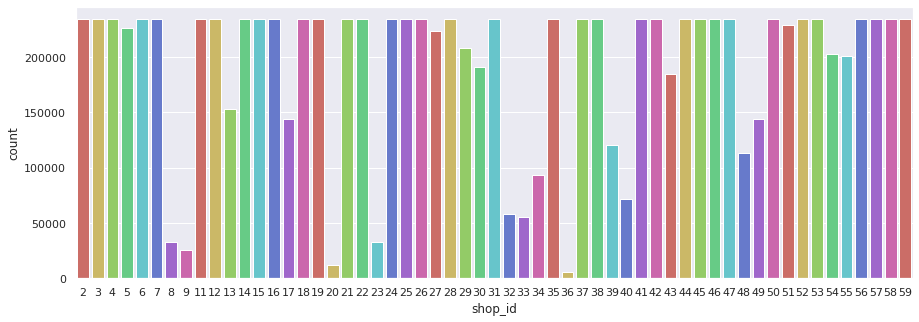

In [60]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=matrix['shop_id'], data=matrix, palette=color)

### Aggregate Sales

In [61]:
train_data['revenue'] = train_data['item_price'] * train_data['item_cnt_day']
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [62]:
group_data = train_data.groupby(by=['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'})
group_data.columns = ['item_cnt_month']
group_data.reset_index(inplace = True)
group_data.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [63]:
matrix = pd.merge(matrix, group_data, on=cols, how='left')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,NaN
1,2,27,0,1.0
2,2,28,0,NaN
3,2,29,0,NaN
4,2,32,0,NaN


In [66]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,0.0
1,2,27,0,1.0
2,2,28,0,0.0
3,2,29,0,0.0
4,2,32,0,0.0


In [67]:
matrix.shape

(10913804, 4)

#### Concat Test into Training

In [68]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [69]:
test_data['date_block_num'] = 34
test_data['date_block_num'] = test_data['date_block_num'].astype(np.int8)
test_data['shop_id'] = test_data['shop_id'].astype(np.int8)
test_data['item_id'] = test_data['item_id'].astype(np.int16)

In [70]:
matrix = pd.concat([matrix, test_data], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix = matrix.drop('ID', axis=1)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,0.0
1,2,27,0,1.0
2,2,28,0,0.0
3,2,29,0,0.0
4,2,32,0,0.0


#### Merge our Features

In [71]:
items_data.drop(['item_name'], axis=1, inplace=True)
items_data.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [72]:
cate_data.head()

,item_category_id,main_cate_id,sub_cate_id
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [73]:
matrix = pd.merge(matrix, shops_data, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items_data, on=['item_id'], how='left')
matrix = pd.merge(matrix, cate_data, on=['item_category_id'], how='left')

In [74]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [75]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['main_cate_id'] = matrix['main_cate_id'].astype(np.int8)
matrix['sub_cate_id'] = matrix['sub_cate_id'].astype(np.int8)

### Implement Lags

In [76]:
# train_data['date_block_num'] += 9
# train_data.head()
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [77]:
def generate_lag(df, months, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
#     print(tmp)
    for month in months:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(month)]
        shifted['date_block_num'] += month
#         print(month)
#         print(shifted)
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
                      
    return df

In [78]:
matrix = generate_lag(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,2,19,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


### Mean Encoding

Date Block

In [79]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Item

In [80]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Shop

In [81]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

Item Category ID

In [82]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

Shop and Item Category ID

In [83]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

Shop and Main Category ID

In [84]:
group = matrix.groupby(['date_block_num', 'shop_id', 'main_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'main_cate_id'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

Shop and Sub Category ID

In [85]:
group = matrix.groupby(['date_block_num', 'shop_id', 'sub_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'sub_cate_id'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

City Code

In [86]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

Item and City Code

In [87]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

Main Category ID

In [88]:
group = matrix.groupby(['date_block_num', 'main_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'main_cate_id'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

Sub Category ID

In [89]:
group = matrix.groupby(['date_block_num', 'sub_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'sub_cate_id'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [90]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trend Analysis

In [91]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [92]:
group = train_data.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.625


In [93]:
group = train_data.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000,28.0
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000,2324.0
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000,549.0
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000,2398.0
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.625,338.0


In [94]:
lags = [1,2,3,4,5,6]
matrix = generate_lag(matrix, lags, 'date_item_avg_item_price')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,28.000,28.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,310.000,549.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,1759.000,2398.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,249.625,338.0,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [96]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [97]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

#### Shop Revenue Trend

In [98]:
group = train_data.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = generate_lag(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

##### Add more Features

In [99]:
matrix['month'] = matrix['date_block_num'] % 12
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


In [100]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31


In [103]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num 

In [104]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

In [105]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

#### Final Preparation

In [106]:
matrix = matrix[matrix.date_block_num > 11]

In [107]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [108]:
matrix.to_pickle('/home/Dropbox/MyData/PredictSales/data.pkl')

In [109]:
gc.collect();

### Prediction Using XGBoost

In [110]:
data = pd.read_pickle('/home/Dropbox/MyData/PredictSales/data.pkl')

In [111]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'main_cate_id',
    'sub_cate_id',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [112]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [113]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.05903	validation_1-rmse:1.04588
[1]	validation_0-rmse:0.96586	validation_1-rmse:0.98034
[2]	validation_0-rmse:0.91851	validation_1-rmse:0.95026
[3]	validation_0-rmse:0.88858	validation_1-rmse:0.93098
[4]	validation_0-rmse:0.86856	validation_1-rmse:0.92269
[5]	validation_0-rmse:0.85428	validation_1-rmse:0.91628
[6]	validation_0-rmse:0.84596	validation_1-rmse:0.91208
[7]	validation_0-rmse:0.83890	validation_1-rmse:0.91287
[8]	validation_0-rmse:0.83472	validation_1-rmse:0.91296
[9]	validation_0-rmse:0.83133	validation_1-rmse:0.91236
[10]	validation_0-rmse:0.82754	validation_1-rmse:0.91447
[11]	validation_0-rmse:0.82429	validation_1-rmse:0.91371
[12]	validation_0-rmse:0.82214	validation_1-rmse:0.91347
[13]	validation_0-rmse:0.82091	validation_1-rmse:0.91386
[14]	validation_0-rmse:0.81963	validation_1-rmse:0.91322
[15]	validation_0-rmse:0.81746	validation_1-rmse:0.91331


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [114]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('/home/Dropbox/MyData/PredictSales/boost_final.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('/home//Dropbox/MyData/PredictSales/xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('/home/Dropbox/MyData/PredictSales/xgb_test.pickle', 'wb'))

In [115]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

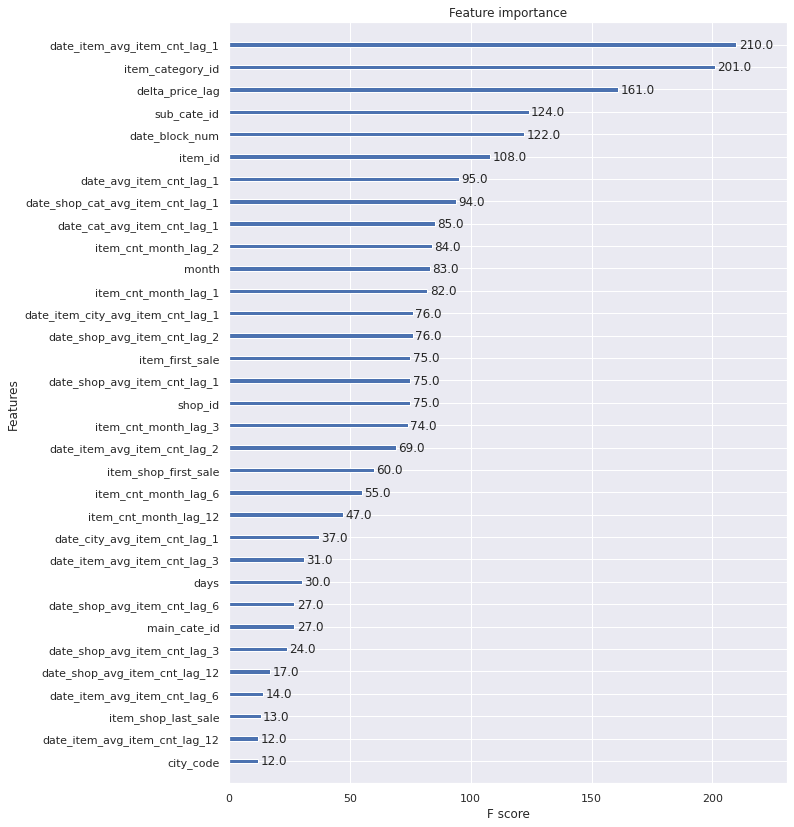

In [116]:
plot_features(model, (10,14))